# Sınıfların spektral yoğunluk grafikleri

In [1]:
import os
import numpy as np
from spectral import *
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter, gaussian_filter,median_filter

# Tanımlar

In [2]:
data_folder = "c:/proje/hasta"
png_folder="c:/proje/png"

# spectral spectral büyük harflerle ilgili warning mesajlarını ekranda gösterme
spectral.settings.envi_support_nonlowercase_params = True

"""Tümörlü hastalar 
008-01, 008-02, 012-01, 012-02, 015-01, 020-01, 021-01, 021-02, 022-03, 025-02, 028-05, 029-04, 
034-02, 034-03, 035-02, 036-02, 037-03, 037-04, 038-01, 039-01, 039-02, 040-01, 040-02, 041-01, 041-02, 042-02, 042-03, 043-01, 043-02, 
050-01, 053-01, 055-02, 056-01, 056-02, 057-01, 058-02
"""

hasta_sayisi=35

# Sınıf isimleri
CLASS_NAMES = {
    1: "Normal Doku",
    2: "Tümör Dokusu",
    3: "Hipervaskülarize Doku",
    4: "Arka plan"
}



# Image filtreleme ve yükleme fonksiyonları

In [3]:
def read_hdr_files(image_path, label_path):
    """
    raw.hdr ve gtMap.hdr dosyalarını okur.
    Args:
        image_path (str): raw.hdr dosya yolu.
        label_path (str): gtMap.hdr dosya yolu.
    Returns:
        tuple: (image_data, label_map)
    """
    image_data = open_image(image_path).load()  # raw.hdr yükleme kodu
    label_map = open_image(label_path).load()  # gtMap.hdr yükleme kodu
    return image_data, label_map


def median(data, filter_size=3):    
    return median_filter(data, size=filter_size)
    
def noise(data, filter_size=5):
    # Uzaysal filtreleme: her bant için uygulanır    
    return uniform_filter(data, size=filter_size)
    """
    filtered_data = np.empty_like(data)
    for i in range(data.shape[2]):  # Bantlar boyunca dön
        filtered_data[:, :, i] = uniform_filter(data[:, :, i], size=filter_size)
    return filtered_data
    """

# Spektral Düzeltme (Gaussian Smoothing)
def gauss(data, sigma=1):    
    return gaussian_filter(data, sigma=(0, 0, sigma))

# Normalize Etme
def normalize(data):    
    """filtered_data = np.empty_like(data)
    for i in range(data.shape[2]):  # Bantlar boyunca dön
        min_val = np.min(data[:, :, i])
        max_val = np.max(data[:, :, i])
        filtered_data[:, :, i] = (data[:, :, i] - min_val) / (data[:, :, i] - min_val+ 1e-9)    
    return filtered_data
    """
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val+ 1e-9)    


# Grafik çizimi

In [4]:
def plot_ortalama_ve_varyans_imzasi(mean_spectra, variance_spectra, baslik="", wavelengths=[],pngfilename=""):   
    # Grafik Çizimi
    plt.figure(figsize=(12, 8))
    
    # 1-4 sınıfları
    colors = ["orange", "green", "red", "blue", "black"]
    num_bands = len(next(iter(mean_spectra.values())))
    
    # X eksenindeki etiketler: Eğer wavelengths boşsa band numaralarını, doluysa wavelengths değerlerini kullan
    if len(wavelengths) > 0:
        x_labels = wavelengths
    else:
        x_labels = range(num_bands)
    
    for cls, cls_scores in mean_spectra.items():
        plt.plot(x_labels, cls_scores, label=CLASS_NAMES[cls], color=colors[cls])
        plt.fill_between(
            x_labels,
            mean_spectra[cls] - variance_spectra[cls],
            mean_spectra[cls] + variance_spectra[cls],
            color=colors[cls],
            alpha=0.2
        )
        """
        plt.plot(
                 (
                     normalize_data(mean_spectra[cls] - variance_spectra[cls])+
                     normalize_data(mean_spectra[cls] + variance_spectra[cls])                    
                 )/2,
                 label=CLASS_NAMES[cls], color=colors[cls])        
        plt.fill_between(
            x_labels,
            normalize_data(mean_spectra[cls] - variance_spectra[cls]),
            normalize_data(mean_spectra[cls] + variance_spectra[cls]),
            color=colors[cls],
            alpha=0.2
        )"""
        
    # X etiketlerini sadece belli aralıklarla göster
    if len(wavelengths)>0:
        # Aralıkları belirleyelim (örneğin, her 5 bandda bir etiket göster)
        step = max(1, len(wavelengths) // 10)  # 10 etiket gösterecek şekilde aralık seç
        selected_wavelengths = wavelengths[::step]  # Her `step` aralığıyla seçilen etiketler
        
        # Etiketleri göster
        plt.xticks(range(0, len(wavelengths), step), selected_wavelengths, rotation=90)   
        
    # Grafik ayarları
    plt.title(f"{baslik}Sınıfların Ortalama ve Varyanslı Spektral İmzaları")
    plt.xlabel("Spektral Bant" if len(wavelengths)==0 else "Dalga Boyu (nm)")
    plt.ylabel("Yoğunluk")
    plt.legend()
    plt.grid(True)
    

    if pngfilename!="":            
        plt.savefig(png_folder+'/'+pngfilename+'.png', dpi=300, bbox_inches='tight')
        print(f"Kayıt Edildi {png_folder+'/'+pngfilename+'.png'}")

    plt.show()
    

# Spektral Bantların Sınıflar için Ayırt Ediciliği (Ortalama ve Varyans)

In [5]:
def ortalama_ve_varyans_imzasi(data_folder,
                               hasta_sayisi=1,
                               hasta='',
                               showplot=False,
                               filename="calibrated_raw",
                               tumorluler=False,
                               png=False,
                               filters=[]
                              ):    
    
    folder_count = 0  # İşlenen klasör sayısını takip et
    verivar=False;
    hastaadet=0;
    islenenhastasayisi=0
    all_scores = {cls: [] for cls in CLASS_NAMES.keys()}
    all_varyans = {cls: [] for cls in CLASS_NAMES.keys()}    
    
    metadata={}
    wavelengths=[]
    islenenhastalar=[]    

    if hasta!='':
       hasta_sayisi=1

    # Her sınıf için boyutları tutacak bir sözlük oluştur
    class_sizes = {cls: 0 for cls in CLASS_NAMES.keys()}
    
    for root, dirs, files in os.walk(data_folder+'/'+hasta):
        dirs.sort()
        image_path = os.path.join(root, filename)
        label_path = os.path.join(root, "gtMap.hdr")

        if os.path.exists(image_path) and os.path.exists(label_path):
            folder_count += 1
            if folder_count > hasta_sayisi:
                break

            verivar=True
            hastaadet+=1

            # Hasta dosyalarını yükle            
            image_data, label_map = read_hdr_files(image_path, label_path)
            

            # matadata bos mu kontolu 1 kez yuklemek icin
            if  len(wavelengths)==0: 
                metadata = image_data.metadata
                if 'wavegroup' in metadata:
                    wavelengths = np.array(metadata['wavegroup'], dtype=str)

            # islenevek filtreleri belirtilen sıraile uygula ve isimlerini dosya adında kullanma için al
            islenenfiltreler='';            
            for filtre in filters:
                print(f"{filtre.__name__} işleniyor")
                islenenfiltreler+=f'_{filtre.__name__}'
                image_data=filtre(image_data)                

            #ana raw dosyada atılan alanları grafige bos olrak ekleme icin 644 olan imageda kullanabilirsin
            #band56 =np.zeros((image_data.shape[0], image_data.shape[1], 56))
            #band126 = np.zeros((image_data.shape[0], image_data.shape[1], 126))
            #image_data=np.concatenate([band56,image_data,band126], axis=2)
            

            print(f"{hastaadet}.Hasta: {image_path} {image_data.shape}")

            # Fazladan boyutları kaldır
            label_map = np.squeeze(label_map)
            
            if label_map.ndim != 2:
                raise ValueError(f"label_map boyutu hatalı: {label_map.shape}. (row, col) şeklinde olmalı.")

            if (verivar):
                num_bands = image_data.shape[2]   
                
                # parmatre olarak sadece tumorluleri işle dendi ise içinde sınıf değeri 2 olan hastaları alıyoruz
                if (tumorluler==True) and (hasta==''):
                    class_mask = (label_map == 2)
                    if np.sum(class_mask) == 0:                    
                        continue    
                    print(f"İşlenen hasta {os.path.basename(root)}")                
                
                islenenhastasayisi+=1
                islenenhastalar.append(os.path.basename(root))
                
                for cls in CLASS_NAMES.keys():
                  class_mask = (label_map == cls)
                  pixel_count = np.sum(class_mask)
    
                  # class_sizes sözlüğüne toplamı ekle
                  class_sizes[cls] += pixel_count                   
                  
                  if pixel_count == 0:
                    # print(f"Sınıf {cls} için veri bulunamadı.")
                    continue                
                                  
                  # Fazladan boyutları sıkıştır
                  image_data=np.squeeze(image_data);
                  num_bands = image_data.shape[2]                   
                  
                  #print(f"Sıkıştırılmış image_data boyutu: {image_data.shape}")                
                  
                  class_scores = []
                  varyans_scores=[]  

                  #image_data=normalize_data(image_data)
                  for band in range(num_bands):
                      band_data = image_data[:, :, band]                      
                      class_pixels = band_data[class_mask]
                      
                      if len(class_pixels) > 1:
                          class_scores.append(np.mean(class_pixels))
                          varyans_scores.append(np.var(class_pixels))
                      else:  
                          class_scores.append(0)
                          varyans_scores.append(0)

                  
                  all_scores[cls].append(class_scores)
                  all_varyans[cls].append(varyans_scores)        

    
    averaged_scores={}
    averaged_varyans={}    

    altbaslik="Tümörlü" if (tumorluler==True) else ""
    
    print(f"İşlenen {altbaslik} hasta sayısı {islenenhastasayisi}");

    print(f"İşlenen {altbaslik} hastalar "+", ".join(islenenhastalar))

    for cls, size in class_sizes.items():
        print(f"Sınıf '{CLASS_NAMES[cls]}' için piksel sayısı: {size}")
    
    if (islenenhastasayisi>0):
        num_bands = image_data.shape[2]
    
        averaged_scores = {
            cls: np.mean(all_scores[cls], axis=0) if all_scores[cls] else np.zeros(num_bands)
            for cls in CLASS_NAMES.keys()
        }
        averaged_varyans = {
            cls: np.mean(all_varyans[cls], axis=0) if all_varyans[cls] else np.zeros(num_bands)
            for cls in CLASS_NAMES.keys()
        }
        
        if (hasta==""):
            baslik=f"({islenenhastasayisi} {altbaslik} Hasta Klasörü) "                
        else:
            baslik=f"(Hasta {hasta}) "       

        
        plot_ortalama_ve_varyans_imzasi(
                averaged_scores,
                averaged_varyans,
                baslik=baslik,
                wavelengths=wavelengths,
                pngfilename="" if png==False else f"{filename.replace('.hdr','')}{islenenfiltreler}_hasta_{hasta if hasta!='' else hasta_sayisi}_islenen_{islenenhastasayisi}"
        )            
    else:
        if (hasta!=""):
            print(f"Hasta {hasta} verisi bulunamadı!")
        else:
            print(f"Herhangi bir {filename} verisi bulunamadı!")
            


## İşlemler

1.Hasta: c:/proje/hasta/043-02\calibrated_raw.hdr (554, 446, 644)
İşlenen  hasta sayısı 1
İşlenen  hastalar 043-02
Sınıf 'Normal Doku' için piksel sayısı: 17236
Sınıf 'Tümör Dokusu' için piksel sayısı: 475
Sınıf 'Hipervaskülarize Doku' için piksel sayısı: 2103
Sınıf 'Arka plan' için piksel sayısı: 1964
Kayıt Edildi c:/proje/png/calibrated_raw_hasta_043-02_islenen_1.png


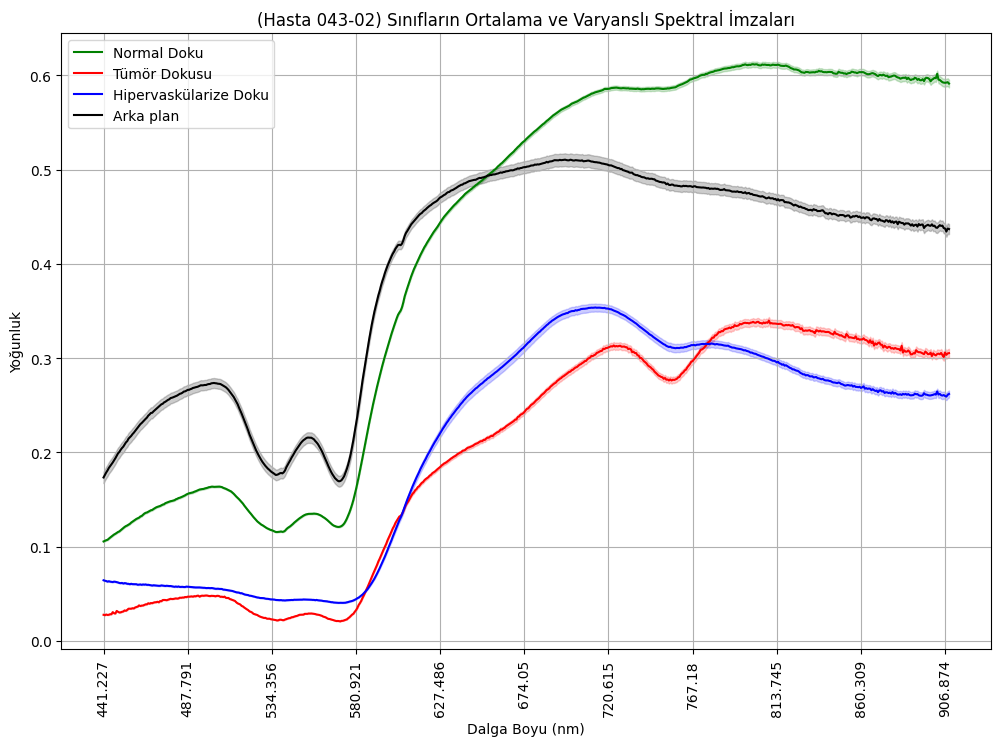

1.Hasta: c:/proje/hasta/043-02\calibrated_par_5.hdr (554, 446, 128)
İşlenen  hasta sayısı 1
İşlenen  hastalar 043-02
Sınıf 'Normal Doku' için piksel sayısı: 17236
Sınıf 'Tümör Dokusu' için piksel sayısı: 475
Sınıf 'Hipervaskülarize Doku' için piksel sayısı: 2103
Sınıf 'Arka plan' için piksel sayısı: 1964
Kayıt Edildi c:/proje/png/calibrated_par_5_hasta_043-02_islenen_1.png


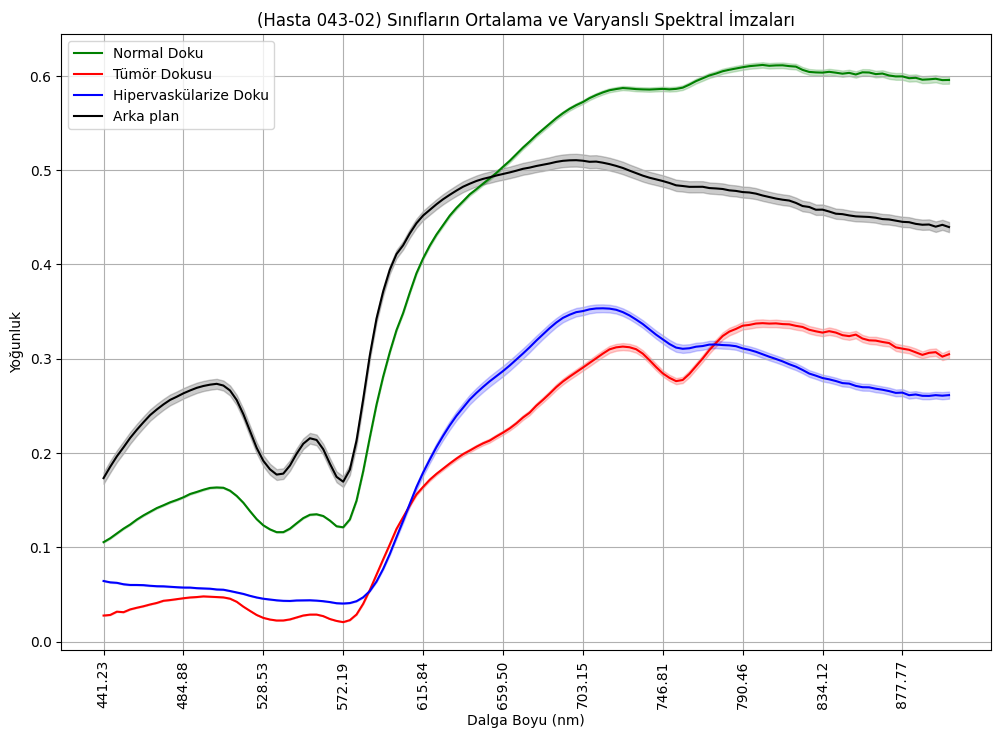

1.Hasta: c:/proje/hasta/043-02\calibrated_ort_5.hdr (554, 446, 128)
İşlenen  hasta sayısı 1
İşlenen  hastalar 043-02
Sınıf 'Normal Doku' için piksel sayısı: 17236
Sınıf 'Tümör Dokusu' için piksel sayısı: 475
Sınıf 'Hipervaskülarize Doku' için piksel sayısı: 2103
Sınıf 'Arka plan' için piksel sayısı: 1964
Kayıt Edildi c:/proje/png/calibrated_ort_5_hasta_043-02_islenen_1.png


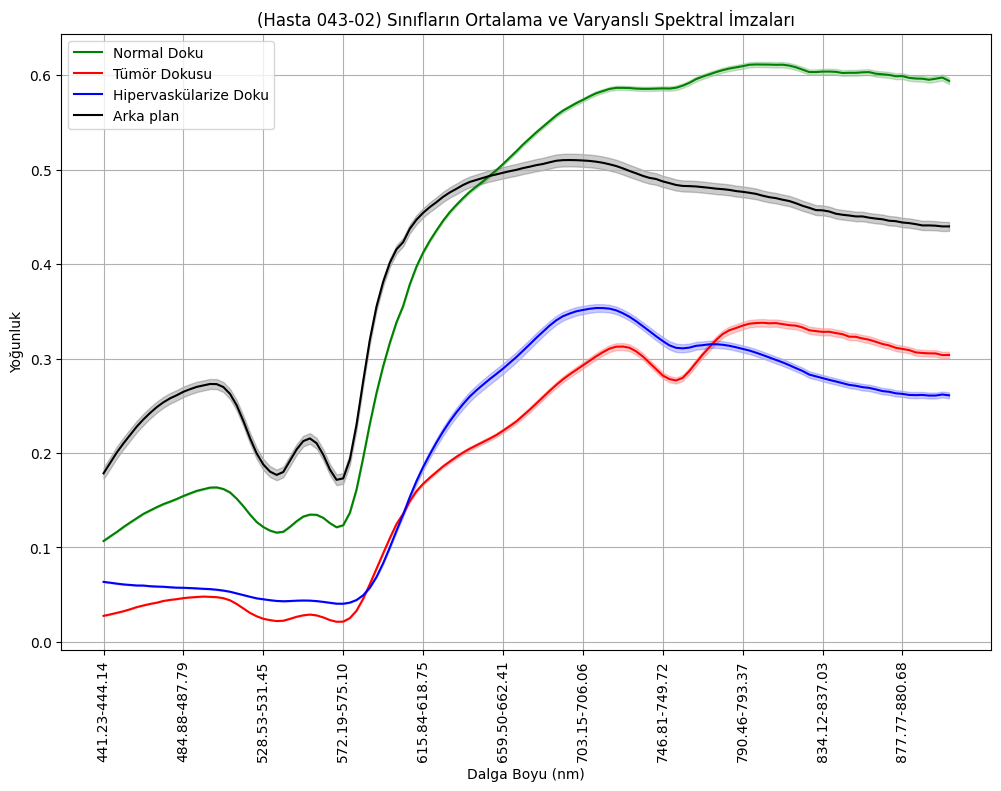

1.Hasta: c:/proje/hasta/043-02\calibrated_pca_5.hdr (554, 446, 128)
İşlenen  hasta sayısı 1
İşlenen  hastalar 043-02
Sınıf 'Normal Doku' için piksel sayısı: 17236
Sınıf 'Tümör Dokusu' için piksel sayısı: 475
Sınıf 'Hipervaskülarize Doku' için piksel sayısı: 2103
Sınıf 'Arka plan' için piksel sayısı: 1964
Kayıt Edildi c:/proje/png/calibrated_pca_5_hasta_043-02_islenen_1.png


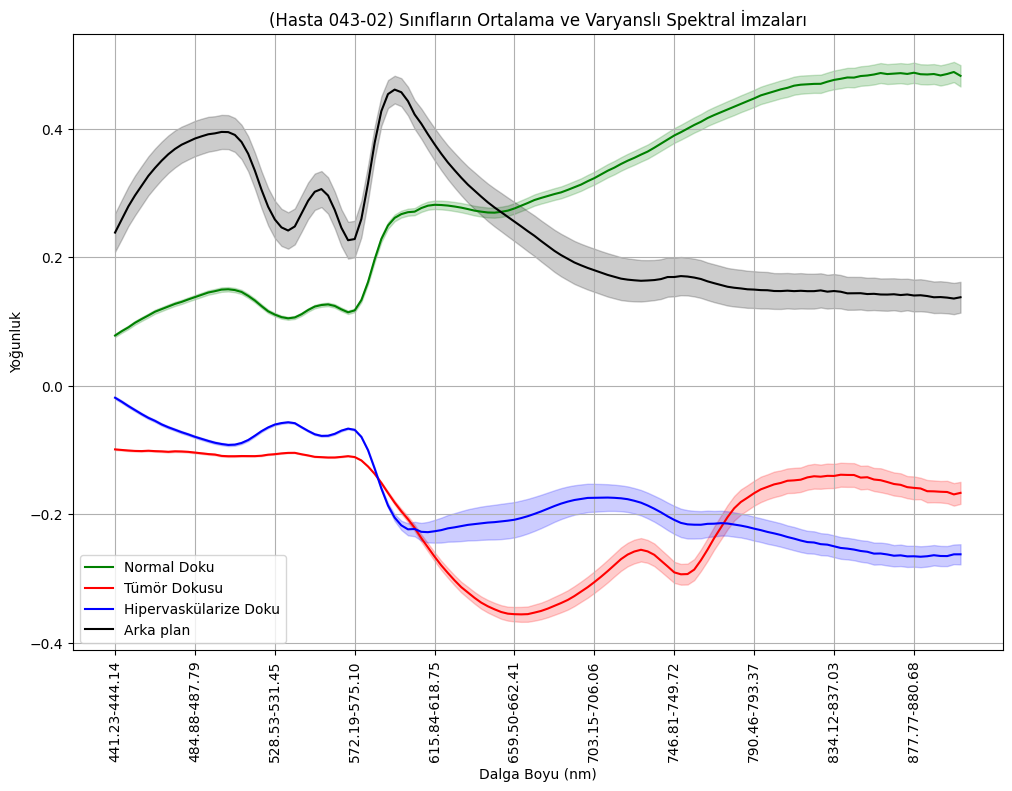

1.Hasta: c:/proje/hasta/043-02\calibrated_ica_5.hdr (554, 446, 128)
İşlenen  hasta sayısı 1
İşlenen  hastalar 043-02
Sınıf 'Normal Doku' için piksel sayısı: 17236
Sınıf 'Tümör Dokusu' için piksel sayısı: 475
Sınıf 'Hipervaskülarize Doku' için piksel sayısı: 2103
Sınıf 'Arka plan' için piksel sayısı: 1964
Kayıt Edildi c:/proje/png/calibrated_ica_5_hasta_043-02_islenen_1.png


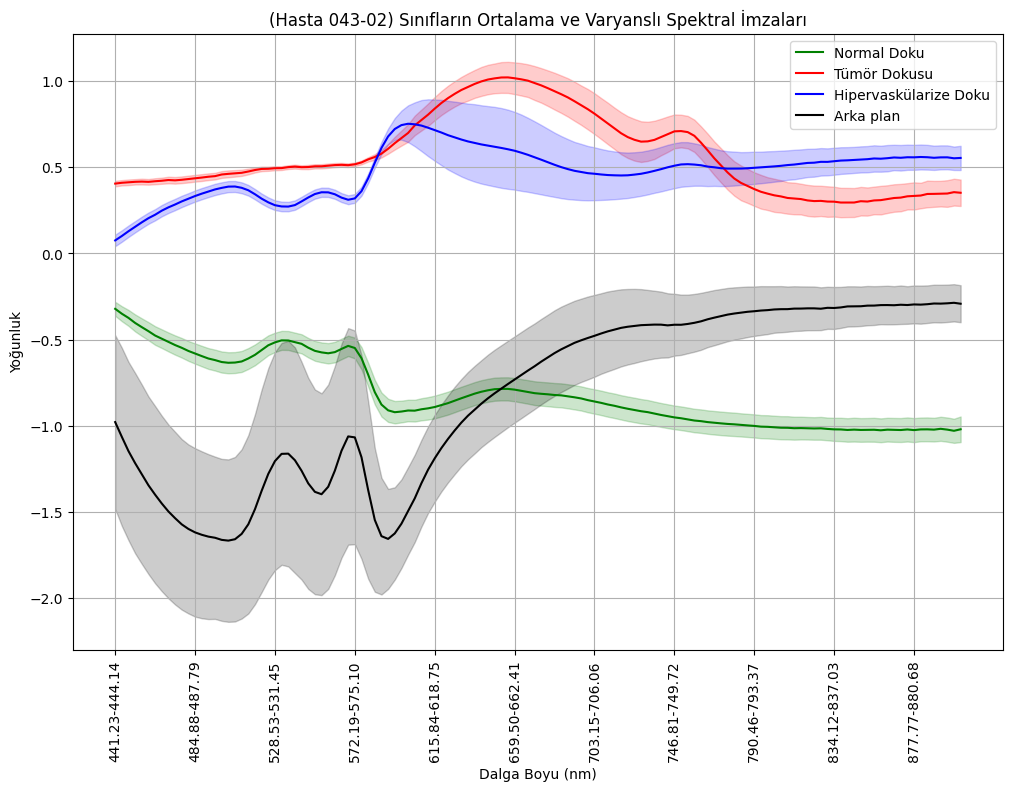

In [6]:
#36 60 70 sırası ile kampanya image toplamları 
#belirtilen hasta klasörü kadar sırası ile okur
hasta_sayisi=36
#hasta klasoru belirtilir ise sasdece  onu göker
hasta='043-02'

# filters=[noise,normalize]
filters=[]

#grafigi dökülmek istenen dosya
filename="calibrated_raw.hdr"
ortalama_ve_varyans_imzasi(data_folder,hasta=hasta,hasta_sayisi=hasta_sayisi,filename=filename,showplot=True,png=True,filters=filters)

filename="calibrated_par_5.hdr"
ortalama_ve_varyans_imzasi(data_folder,hasta=hasta,hasta_sayisi=hasta_sayisi,filename=filename,showplot=True,png=True,filters=filters)

filename="calibrated_ort_5.hdr"
ortalama_ve_varyans_imzasi(data_folder,hasta=hasta,hasta_sayisi=hasta_sayisi,filename=filename,showplot=True,png=True,filters=filters)

filename="calibrated_pca_5.hdr"
ortalama_ve_varyans_imzasi(data_folder,hasta=hasta,hasta_sayisi=hasta_sayisi,filename=filename,showplot=True,png=True,filters=filters)

filename="calibrated_ica_5.hdr"
ortalama_ve_varyans_imzasi(data_folder,hasta=hasta,hasta_sayisi=hasta_sayisi,filename=filename,showplot=True,png=True,filters=filters)


# Sınıfların Bantlardaki Genel Görüntüden Ayrışımı Cohen

In [19]:
def calculate_cohen(image_data, label_map, num_classes):
    """
    Her sınıf için bantların genel piksellerden ayrışma skorlarını hesaplar.
    Args:
        image_data (np.ndarray): Hiperspektral görüntü (row, col, bands).
        label_map (np.ndarray): Piksel sınıf etiket haritası (row, col).
        num_classes (int): Sınıf sayısı.

    Returns:
        dict: Her sınıf için bantların ayrışma skorları.
    """
    num_bands = image_data.shape[2]
    print(f"Sınıf sayısı: {num_classes}")
    print(f"Bant sayısı: {num_bands}")
    separation_scores = {cls: [] for cls in range(1, num_classes)}  # 0 sınıfı dikkate alınmaz

    for band in range(num_bands):
        band_data = image_data[:, :, band];

        band_data = band_data.flatten()  # Bandı 1D hale getir
        
        full_labeledmask=(label_map.flatten() > 0)
        classed_band_data =band_data[full_labeledmask]
        

        overall_mean = np.mean(classed_band_data)
        overall_std = np.std(classed_band_data)

        for cls in range(1, num_classes):
            class_mask = (label_map.flatten() == cls)
            class_pixels = band_data[class_mask]
            if len(class_pixels) > 1:
                class_mean = np.mean(class_pixels)
                class_std = np.std(class_pixels)

                # Cohen's d ile ayrışma hesapla
                if overall_std > 0:
                    cohen_d = (class_mean - overall_mean) / overall_std
                else:
                    cohen_d = 0
                separation_scores[cls].append(cohen_d)
            else:
                separation_scores[cls].append(0)

    return separation_scores


def plot_cohen_scores(separation_scores):
    """
    Ayrışma skorlarını sınıflara göre görselleştirir.

    Args:
        separation_scores (dict): Her sınıf için ayrışma skorları.
        num_bands (int): Bant sayısı.
    """
    plt.figure(figsize=(12, 6))

    num_bands = len(next(iter(scores.values())))  # İlk sınıfın bant sayısını al
    for cls, cls_scores in scores.items():
        plt.plot(range(num_bands), cls_scores, label=CLASS_NAMES[cls])
    plt.xlabel("Spektral Bant")
    plt.ylabel("Ayrışma Skoru (Cohen's d)")
    plt.title("Her Sınıf İçin (Cohen's d) Ayrışma Skorları")
    plt.legend()
    plt.grid(True)
    plt.show()



def process_all_patients_for_cohens(data_folder, hasta_sayisi=1):
    all_scores = {cls: [] for cls in CLASS_NAMES.keys()}
    folder_count = 0  # İşlenen klasör sayısını takip et

    for root, dirs, files in os.walk(data_folder):
        dirs.sort()
        image_path = os.path.join(root, "calibrated_raw.hdr")
        label_path = os.path.join(root, "gtMap.hdr")

        if os.path.exists(image_path) and os.path.exists(label_path):
            # Hasta dosyalarını yükle
            print(f"Hasta: {image_path}")
            image_data, label_map = read_hdr_files(image_path, label_path)

            image_data=normalize(image_data);

            band56 =np.zeros((image_data.shape[0], image_data.shape[1], 56))
            band126 = np.zeros((image_data.shape[0], image_data.shape[1], 126))
            image_data=np.concatenate([band56,image_data,band126], axis=2)

            # Ayrışma skorlarını hesapla
            separation_scores = calculate_cohen(image_data, label_map, num_classes=len(CLASS_NAMES)+1)

            # Her hasta için ayrışma skorlarını biriktir
            for cls in separation_scores.keys():
                all_scores[cls].append(separation_scores[cls])

            folder_count += 1  # Klasör sayısını artır
            if folder_count >= hasta_sayisi:  # hasta_sayisi kadar işlem yap
                break

    # Her sınıf için bant skorlarını ortala
    averaged_scores = {cls: np.mean(all_scores[cls], axis=0) if all_scores[cls] else np.zeros(image_data.shape[2])
                       for cls in CLASS_NAMES.keys()}



    return averaged_scores


## işlemler

Hasta: c:/proje/hasta\004-02\calibrated_raw.hdr
Sınıf sayısı: 5
Bant sayısı: 826
Hasta: c:/proje/hasta\005-01\calibrated_raw.hdr
Sınıf sayısı: 5
Bant sayısı: 826
Hasta: c:/proje/hasta\007-01\calibrated_raw.hdr
Sınıf sayısı: 5
Bant sayısı: 826
Hasta: c:/proje/hasta\008-01\calibrated_raw.hdr
Sınıf sayısı: 5
Bant sayısı: 826
Hasta: c:/proje/hasta\008-02\calibrated_raw.hdr
Sınıf sayısı: 5
Bant sayısı: 826


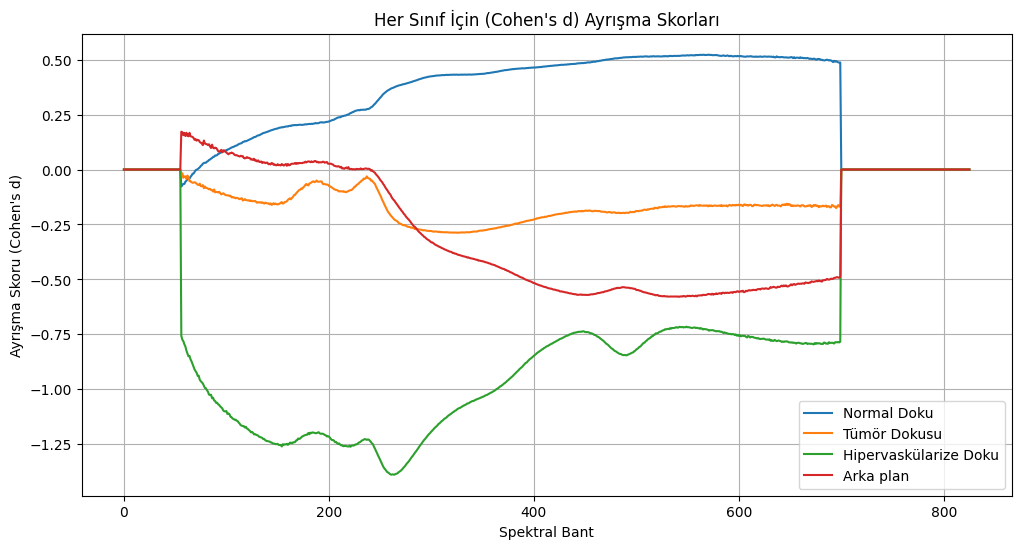

In [20]:
hasta_sayisi=5
scores = process_all_patients_for_cohens(data_folder,hasta_sayisi)
plot_cohen_scores(scores)
